In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
X, y = pd.read_csv('task-1-brain-age-prediction/X_train.csv'), pd.read_csv('task-1-brain-age-prediction/y_train.csv')

In [3]:
X.drop(labels='id', axis=1, inplace=True)
y.drop(labels='id', axis=1, inplace=True)

In [4]:
# data imputing with the median
X.fillna(X.mean(), inplace=True)

In [5]:
print(X.shape)
X = X.drop_duplicates()
print(X.shape)

(1212, 832)
(1212, 832)


In [6]:
# Remove columns with zero variance
mask_ = X.var(axis=0) != 0
X = X.loc[:, mask_]
print(X.shape)

(1212, 828)


In [7]:
print(X.isnull().sum().sum()) # check imputer

0


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
print(type(X_train), type(X_test), type(y_train), type(y_test))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [10]:
from sklearn.preprocessing import StandardScaler, RobustScaler

def filter_multicolinearity(X_train, sigma):
    corr_matrix = np.triu(np.corrcoef(X_train, rowvar=False))
    np.fill_diagonal(corr_matrix, val=0)
    mask_multicorr = (corr_matrix < sigma).all(axis=1)
    return mask_multicorr

# Transform the distribution, so that it looks more uniform
X_train_index, X_train_columns, X_test_index, X_test_columns = X_train.index, X_train.columns, X_test.index, X_test.columns

# Quantile Transformer
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# back to pandas
X_train = pd.DataFrame(X_train, index=X_train_index, columns=X_train_columns)
X_test = pd.DataFrame(X_test, index=X_test_index, columns=X_test_columns)

# compute the feature_corr
print(f'Shape before feature selection (X_train//X_test) is {(X_train.shape, X_test.shape)}')
feature_corr = X_train.corrwith(y_train.squeeze()) > 0.15
X_train, X_test = X_train.loc[:, feature_corr], X_test.loc[:, feature_corr]
print(f'Shape after feature selection (X_train//X_test) is {(X_train.shape, X_test.shape)}')

# multicolinearity removal
print(f'Shape before mutlicolinearity removal (X_train//X_test) is {X_train.shape, X_test.shape}')
sigma_th = 0.8
mask_features = filter_multicolinearity(X_train, sigma_th)
X_train = X_train.loc[:, mask_features]
X_test = X_test.loc[:, mask_features]
print(f'Shape after multicolinearity removal (X_train//X_test) is {X_train.shape, X_test.shape}')



Shape before feature selection (X_train//X_test) is ((969, 828), (243, 828))
Shape after feature selection (X_train//X_test) is ((969, 21), (243, 21))
Shape before mutlicolinearity removal (X_train//X_test) is ((969, 21), (243, 21))
Shape after multicolinearity removal (X_train//X_test) is ((969, 14), (243, 14))


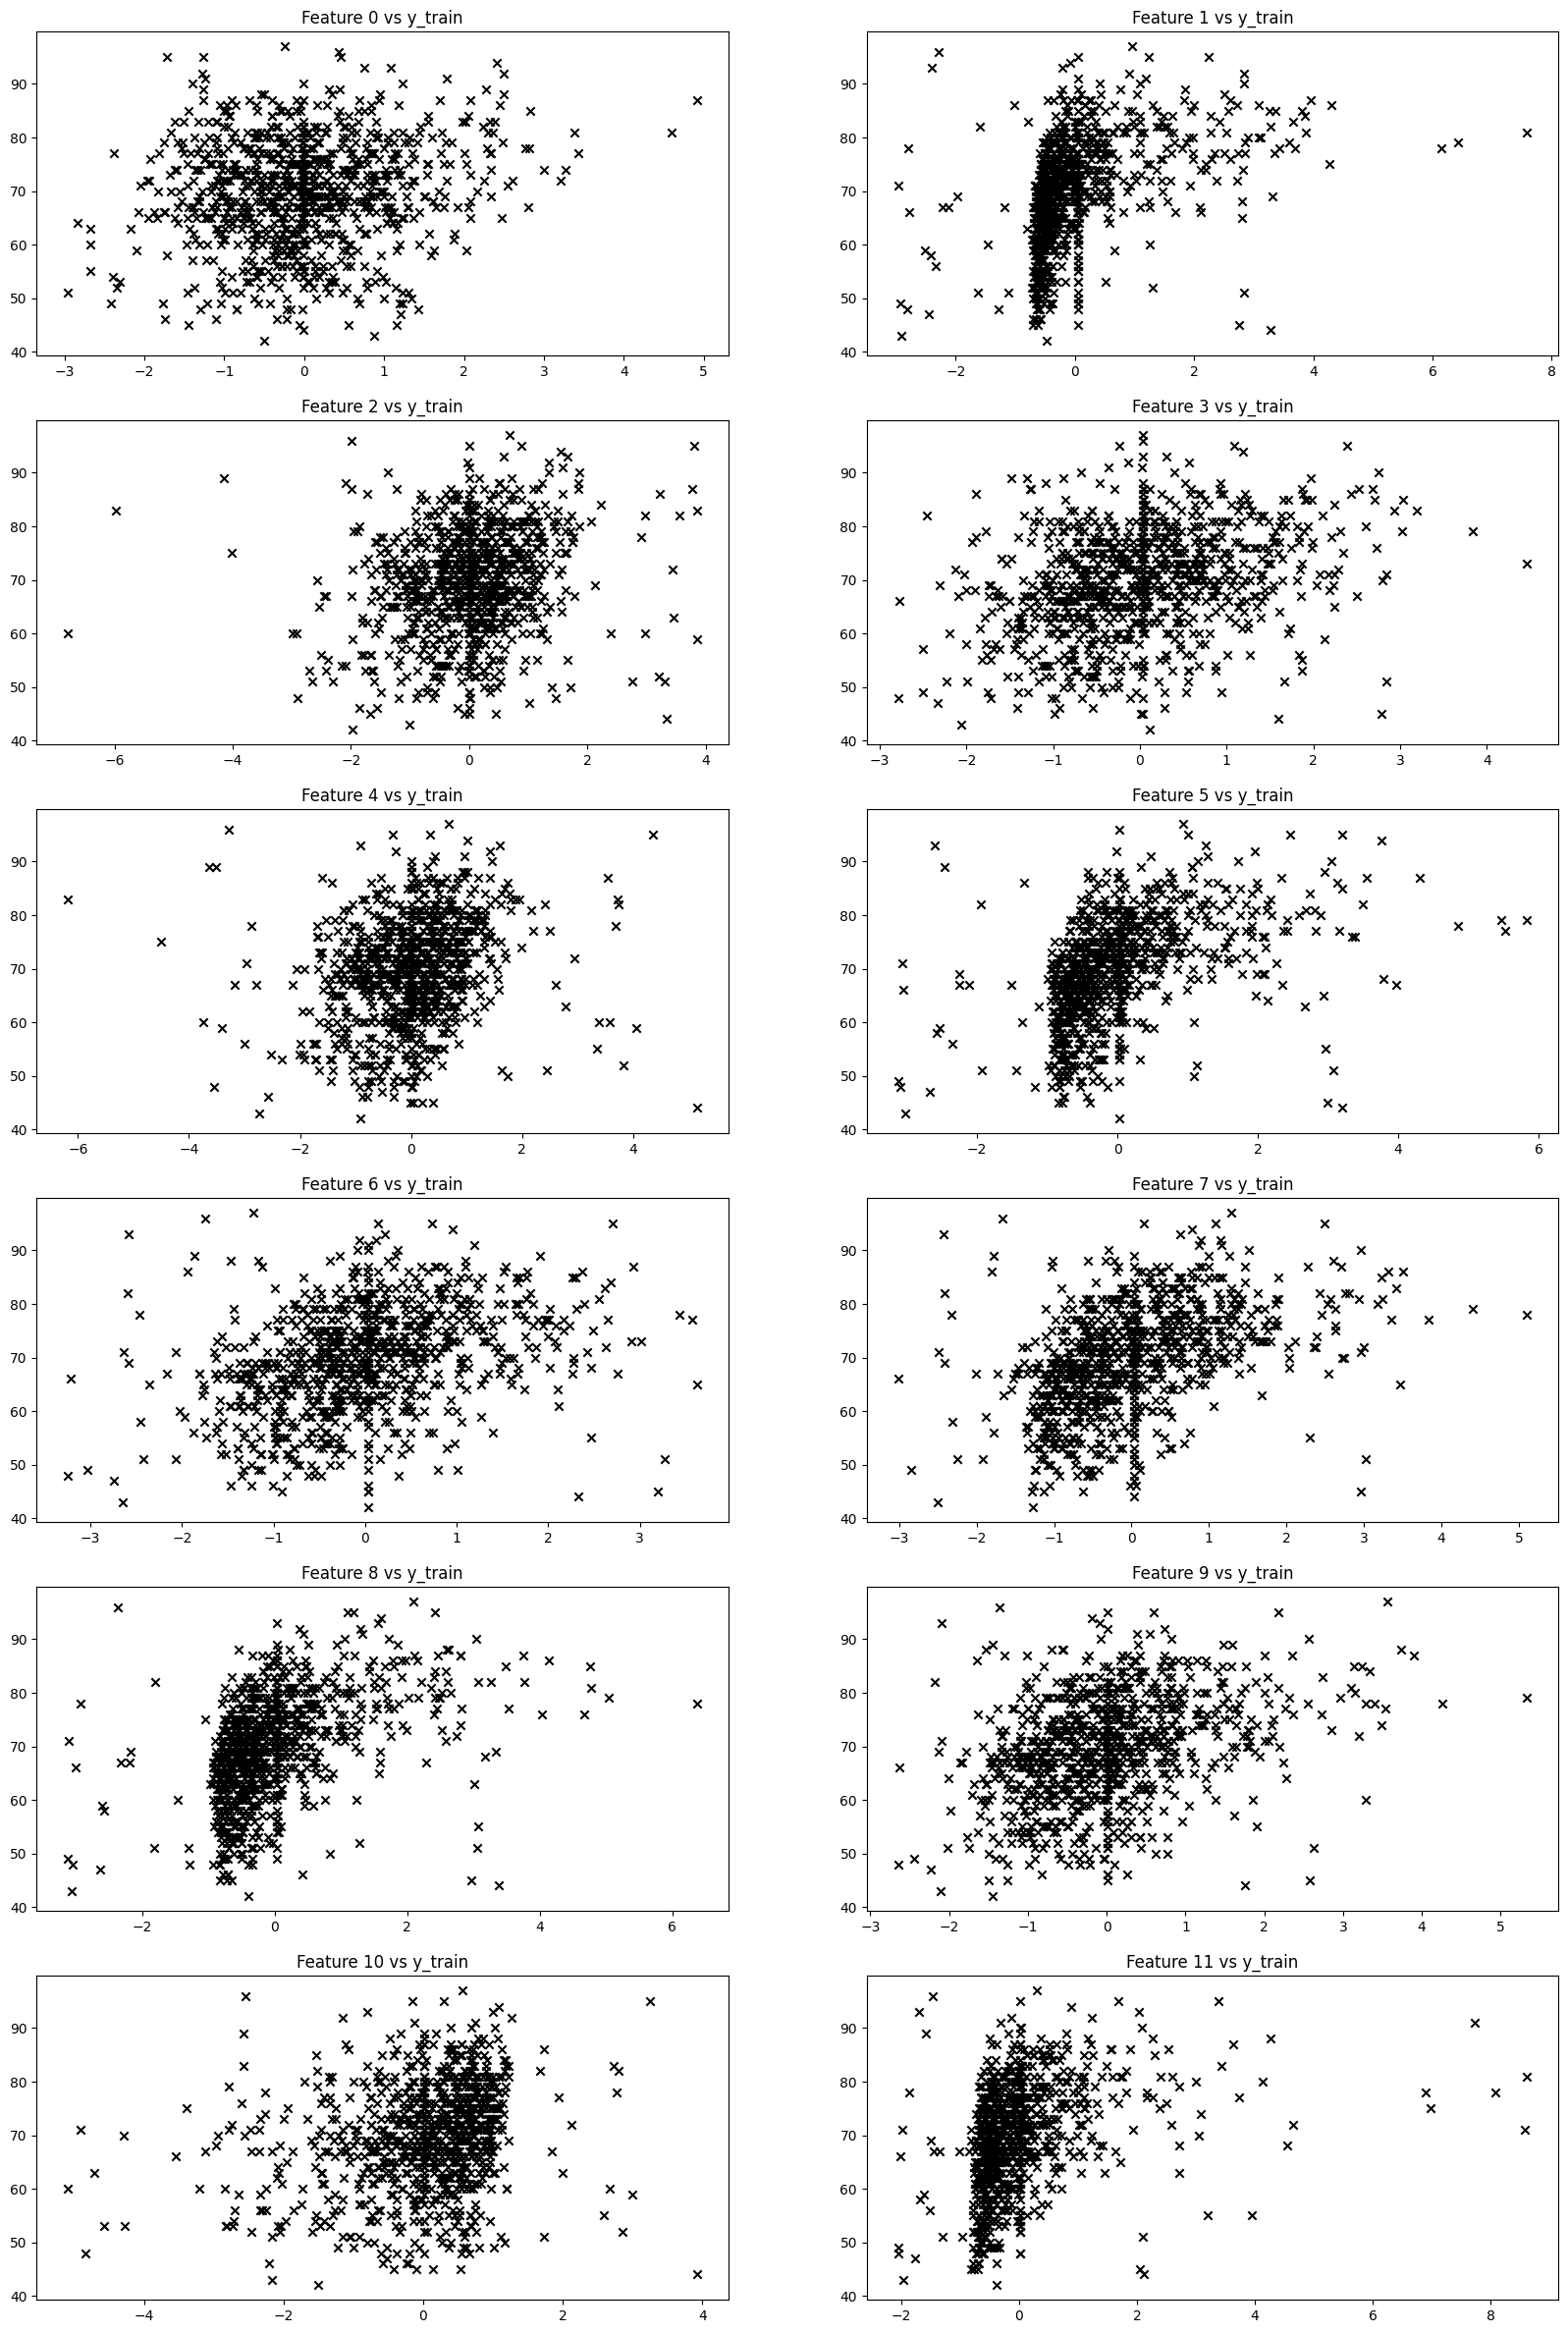

In [11]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(6, 2, figsize=(20, 30))
for i in range(12):
    axes[i // 2, i % 2].scatter(X_train.iloc[:, i], y_train, marker='x', color='black')
    axes[i // 2, i % 2].set_title(f'Feature {i} vs y_train')

plt.show()

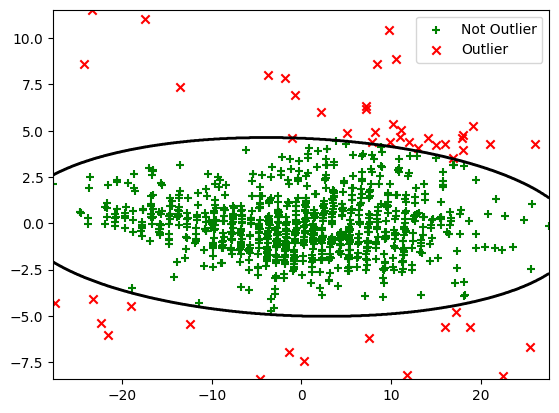

In [12]:
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope

fig, ax = plt.subplots()

# Consider the points (x, y) jointly
Xy_train = pd.concat([X_train, y_train], axis=1)
pca = PCA(n_components=2)
Xy_project = pca.fit_transform(Xy_train)

# Outlier analysis --> EllipticEnvelope (Gaussian)
xx, yy = np.meshgrid(np.linspace(Xy_project[:, 0].min(), \
Xy_project[:, 0].max(), 1000), np.linspace(Xy_project[:, 1].min(), \
    Xy_project[:, 1].max(), 1000))

elliptic_env = EllipticEnvelope(contamination=0.05)
outliers = elliptic_env.fit_predict(Xy_project)
mask_outliers_out = outliers != -1
Xy_project_not_outliers = Xy_project[mask_outliers_out, :]
Xy_project_outliers = Xy_project[~mask_outliers_out, :]

ax.scatter(Xy_project_not_outliers[:, 0], Xy_project_not_outliers[:, 1], marker='+', color='green')
ax.scatter(Xy_project_outliers[:, 0], Xy_project_outliers[:, 1], marker='x', color='red')
Z = elliptic_env.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")
ax.legend(['Not Outlier', 'Outlier'])

plt.show()

In [13]:
print((outliers == -1).sum()) # Total Number of outliers detected using PCA and Gaussian Enveloppe

49


In [14]:
X_train, y_train = X_train.loc[mask_outliers_out, :], y_train[mask_outliers_out]

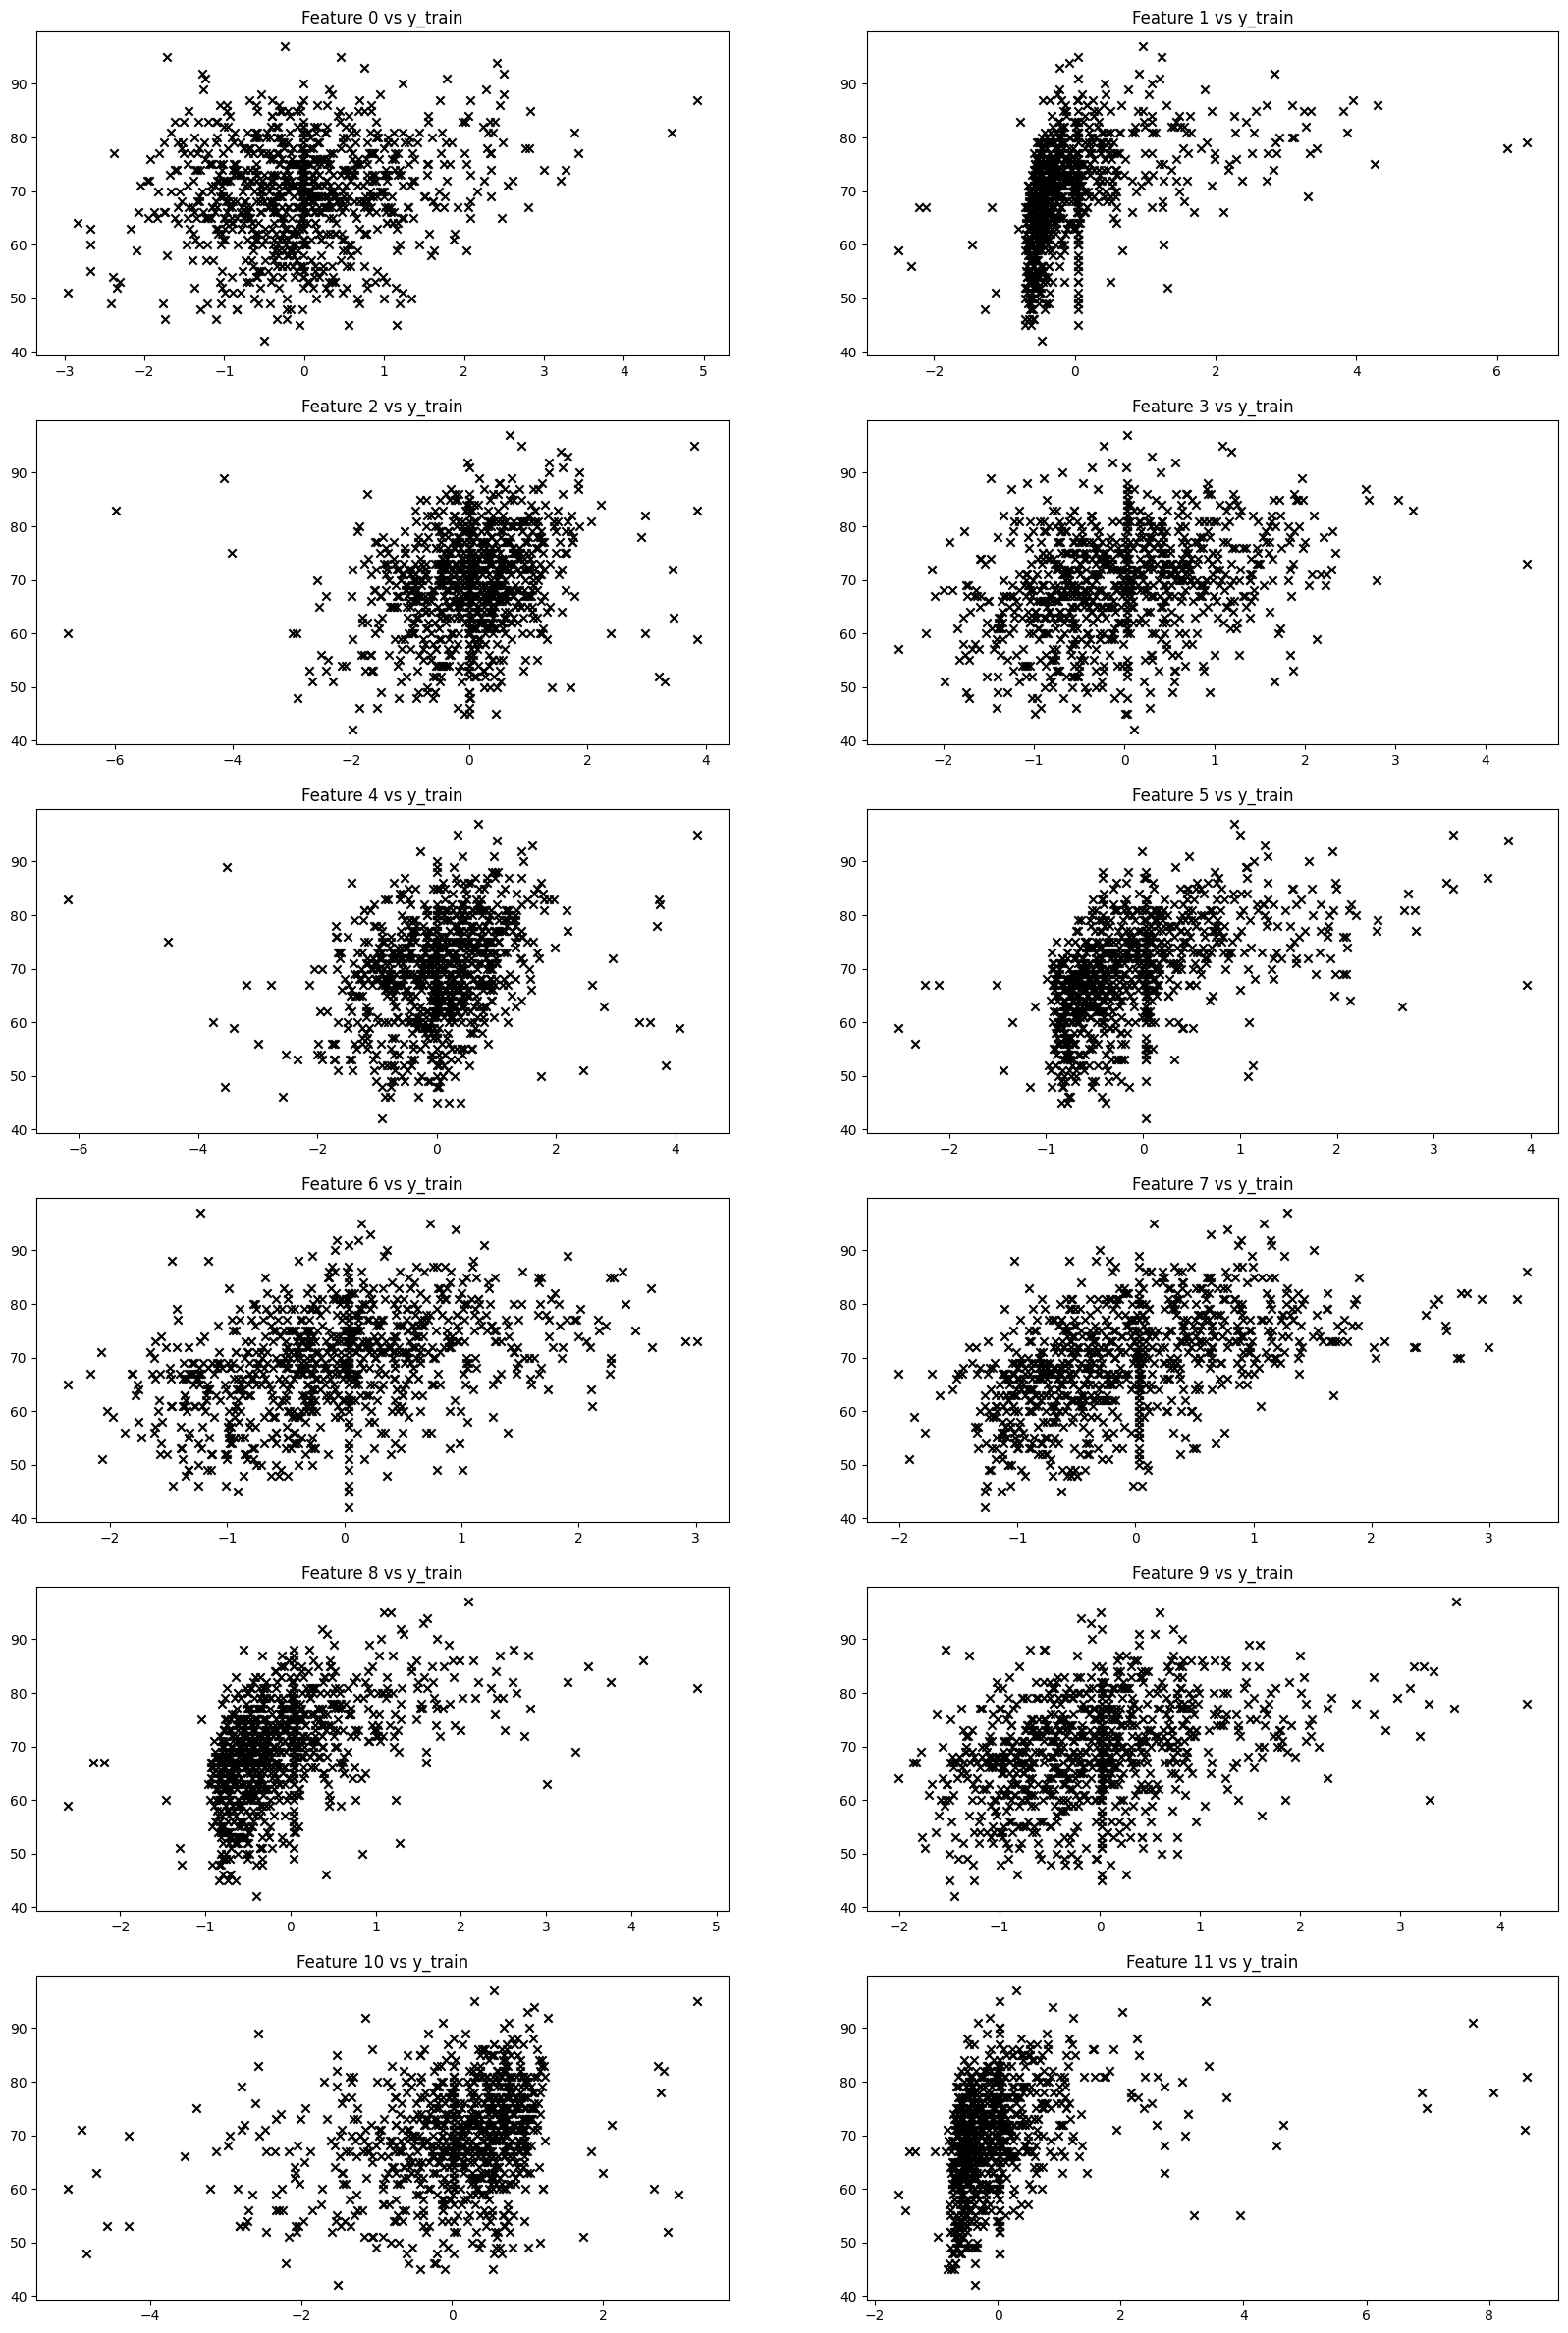

In [15]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(6, 2, figsize=(20, 30))
for i in range(12):
    axes[i // 2, i % 2].scatter(X_train.iloc[:, i], y_train, marker='x', color='black')
    axes[i // 2, i % 2].set_title(f'Feature {i} vs y_train')

plt.show()

In [16]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

svr = Pipeline([ 
    ('svr', SVR())
])
param_grid = { 
    'svr__kernel' : ['poly', 'rbf', 'sigmoid'], 
    'svr__degree' : [3, 4, 5, 6, 7], 
    'svr__gamma' : ['scale', 'auto']
}

grid = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

svr_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, svr_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, svr_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

----
Train r2 score: 0.49772876512355635
Test r2 score: 0.40570923307888984
----


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

random_forest_regressor = Pipeline([ 
    ('random_forest_regressor', RandomForestRegressor())
])
param_grid = { 
    'random_forest_regressor__n_estimators' : [50, 100, 150, 200, 250], 
    'random_forest_regressor__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'random_forest_regressor__max_depth' : [3, 5, 7, 9, 11, 13, 15, 17]
}

grid = GridSearchCV(estimator=random_forest_regressor, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

random_forest_regressor_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, random_forest_regressor_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, random_forest_regressor_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV] END random_forest_regressor__criterion=squared_error, random_forest_regressor__max_depth=3, random_forest_regressor__n_estimators=50; total time=   0.2s
[CV] END random_forest_regressor__criterion=squared_error, random_forest_regressor__max_depth=3, random_forest_regressor__n_estimators=50; total time=   0.2s
[CV] END random_forest_regressor__criterion=squared_error, random_forest_regressor__max_depth=3, random_forest_regressor__n_estimators=50; total time=   0.2s
[CV] END random_forest_regressor__criterion=squared_error, random_forest_regressor__max_depth=3, random_forest_regressor__n_estimators=50; total time=   0.2s
[CV] END random_forest_regressor__criterion=squared_error, random_forest_regressor__max_depth=3, random_forest_regressor__n_estimators=50; total time=   0.2s
[CV] END random_forest_regressor__criterion=squared_error, random_forest_regressor__max_depth=3, random_forest_regressor__n_estimators=100; total t

In [23]:
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

----
Train r2 score: 0.49772876512355635
Test r2 score: 0.40570923307888984
----


In [19]:
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.kernel_ridge import KernelRidge

kernel_ridge = Pipeline([ 
    ('kernel_ridge', KernelRidge())
])
param_grid = { 
    'kernel_ridge__kernel' : ['poly', 'rbf', 'linear', 'laplacian'], 
    'kernel_ridge__degree' : [3, 4, 5, 6, 7], 
    'kernel_ridge__gamma' : [None, 0.1, 0.5, 1, 2, 4, 8]
}

grid = GridSearchCV(estimator=kernel_ridge, param_grid=param_grid, \
    cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

ridge_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, svr_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, svr_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

----
Train r2 score: 0.49772876512355635
Test r2 score: 0.40570923307888984
----


/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [33]:
import xgboost as xgb 

regressor=xgb.XGBRegressor(eval_metric='rmse')

regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [34]:
r2_score(y_train, regressor.predict(X_train))

0.9997875690460205

In [35]:
r2_score(y_test, regressor.predict(X_test))

0.4673801064491272

NameError: name 'kfold' is not defined

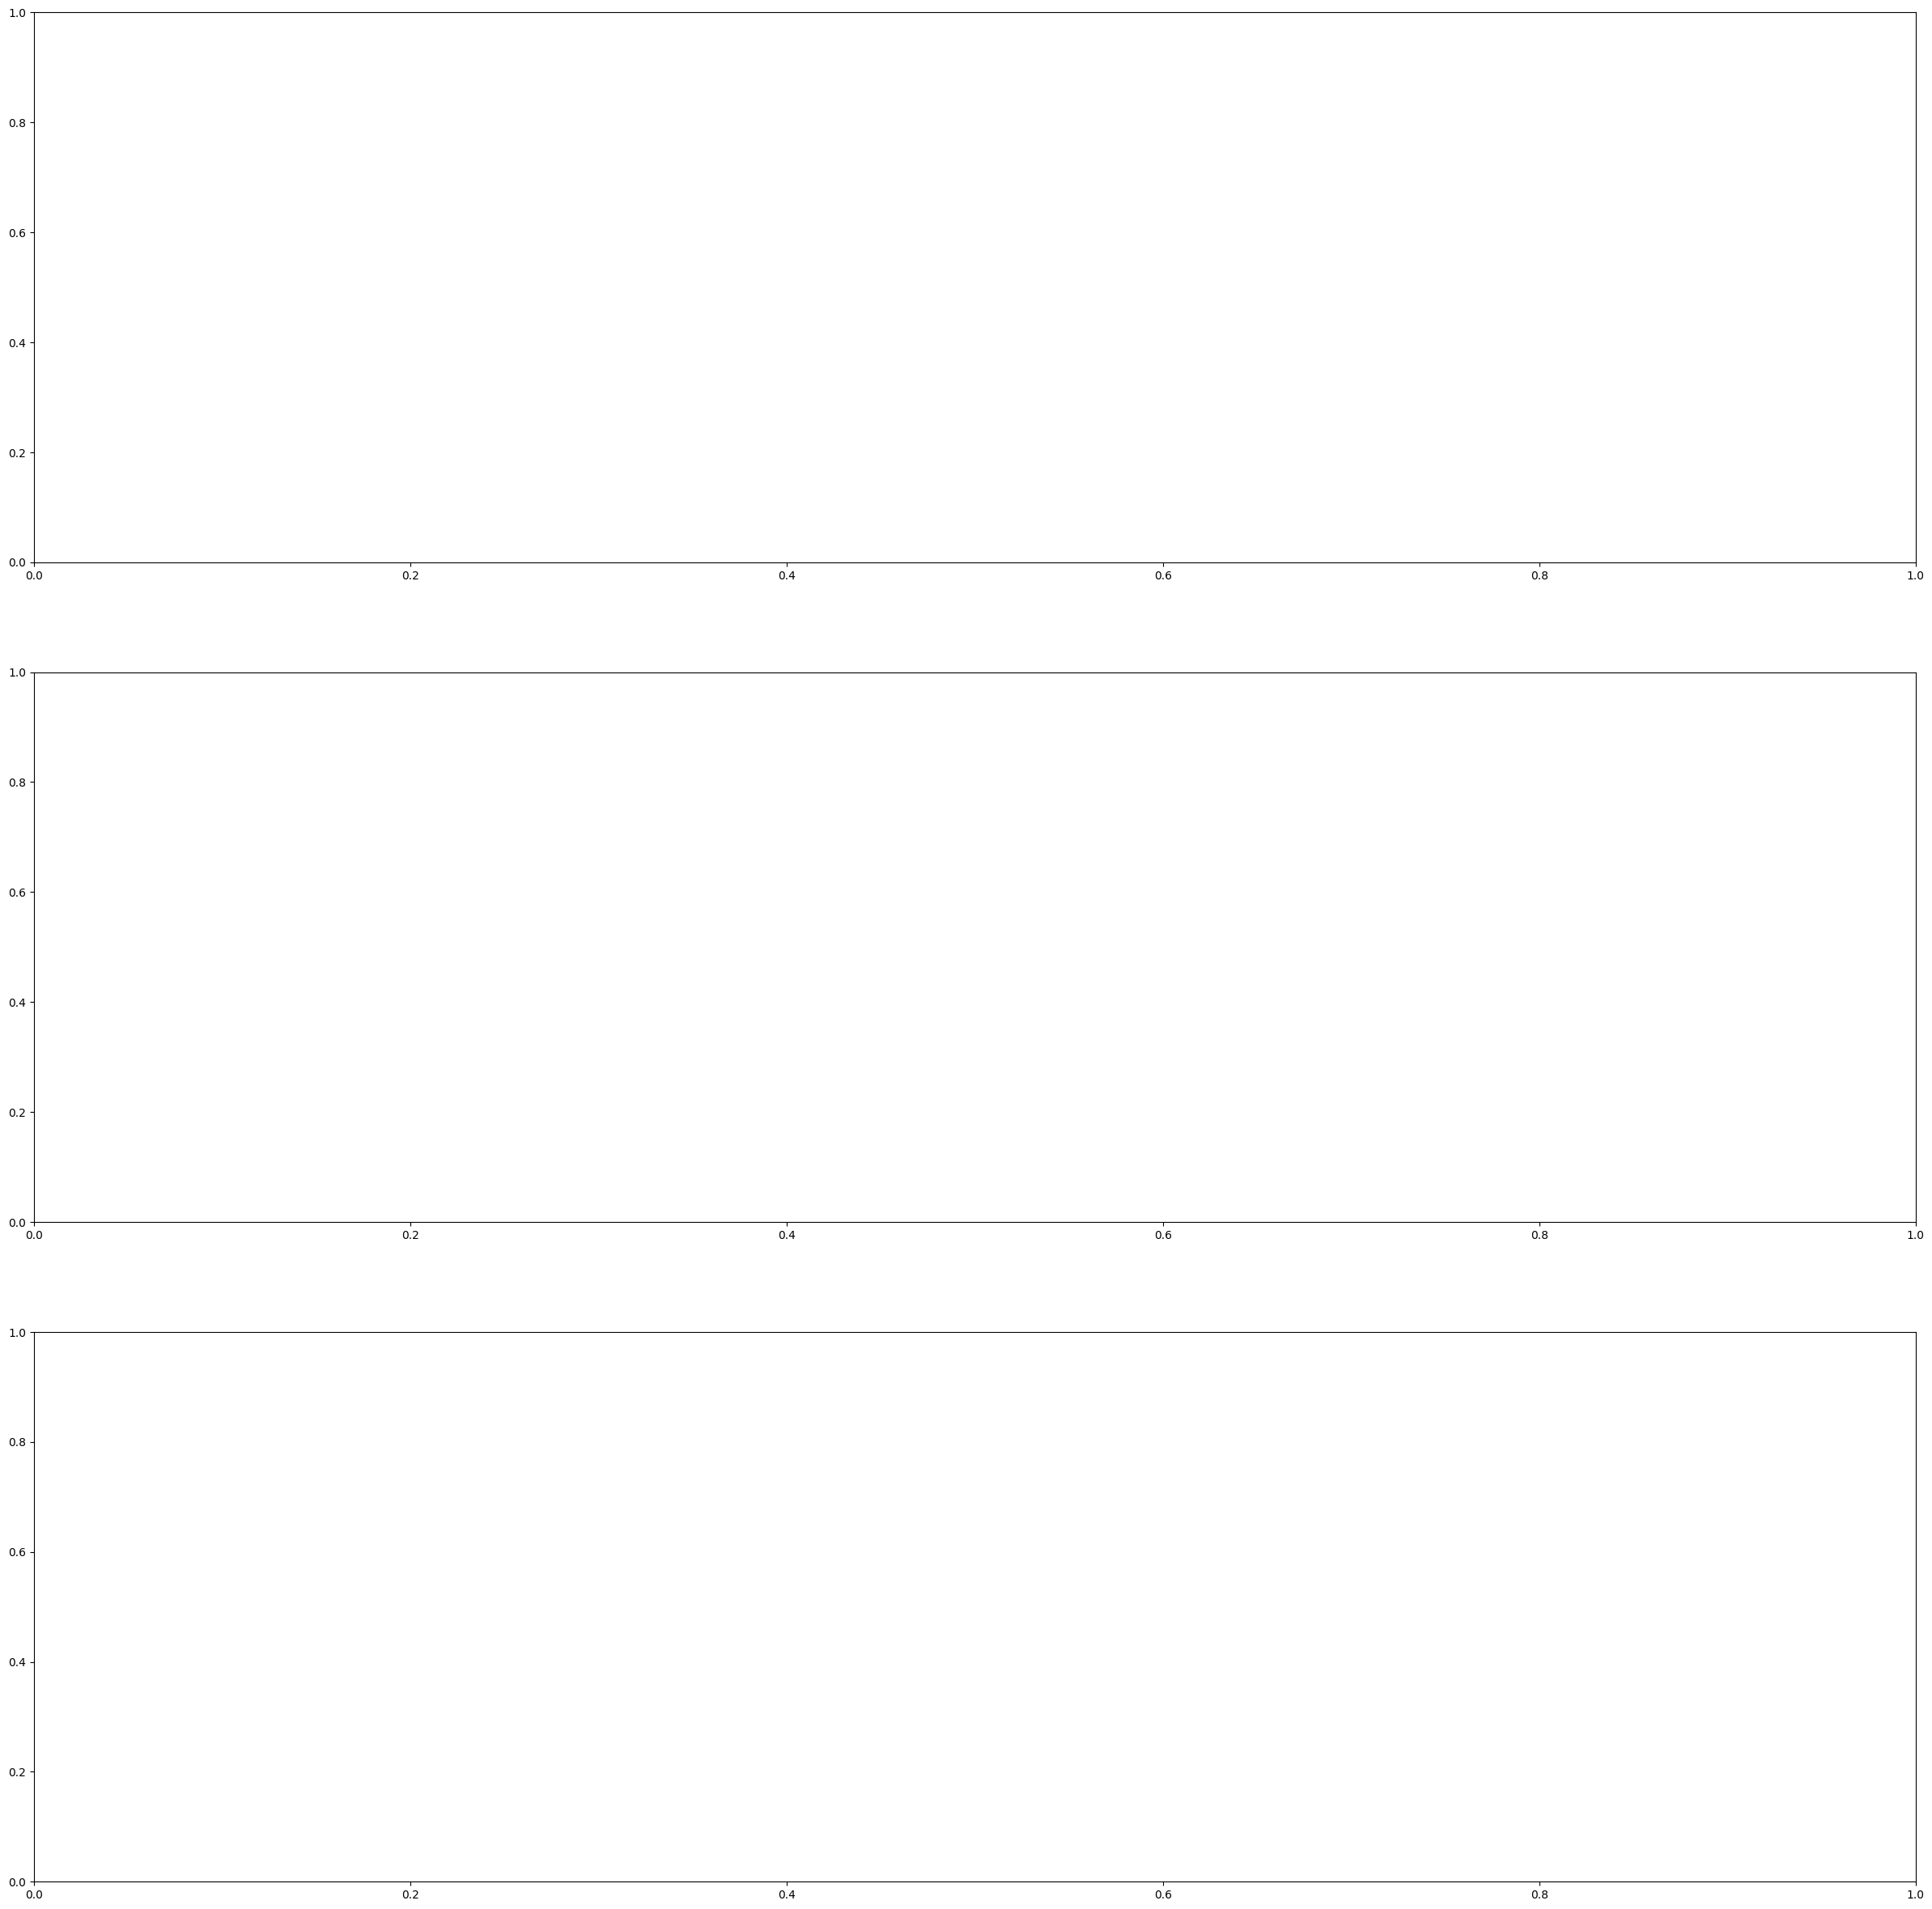

In [20]:
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.kernel_ridge import KernelRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import QuantileTransformer


def filter_multicolinearity(X_train, sigma):
    corr_matrix = np.triu(np.corrcoef(X_train, rowvar=False))
    np.fill_diagonal(corr_matrix, val=0)
    mask_multicorr = (corr_matrix < sigma).all(axis=1)
    return mask_multicorr

fig, axes = plt.subplots(3, figsize=(30, 30))

overall_best_kernel_ridge = None 
overall_best_score = -np.inf
mean_r2_score = 0

for i, (train_index, test_index) in enumerate(kfold.split(X)):
    # K fold --> train test split
    X_train, X_test, y_train, y_test = X.iloc[train_index, :], X.iloc[test_index, :], y.iloc[train_index], y.iloc[test_index]
        
    # First we do feature scaling
    X_train_index, X_train_columns, X_test_index, X_test_columns = X_train.index, X_train.columns, \
        X_test.index, X_test.columns
        
    scaler = QuantileTransformer(n_quantiles=X_train.shape[0], output_distribution='uniform')
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = pd.DataFrame(X_train, index=X_train_index, columns=X_train_columns)
    X_test = pd.DataFrame(X_test, index=X_test_index, columns=X_test_columns)
    
    # First we do feature selection
    # -------> Correlation
    print(f'Shape before feature selection (X_train//X_test) is {(X_train.shape, X_test.shape)}')
    feature_corr = X_train.corrwith(y_train.squeeze()) > 0.1
    X_train, X_test = X_train.loc[:, feature_corr], X_test.loc[:, feature_corr]
    print(f'Shape after feature selection (X_train//X_test) is {(X_train.shape, X_test.shape)}')
    # -------> Multicolinearity removal
    print(f'Shape before mutlicolinearity removal (X_train//X_test) is {X_train.shape, X_test.shape}')
    sigma_th = 0.8
    mask_features = filter_multicolinearity(X_train, sigma_th)
    X_train = X_train.loc[:, mask_features]
    X_test = X_test.loc[:, mask_features]
    print(f'Shape after multicolinearity removal (X_train//X_test) is {X_train.shape, X_test.shape}')
    
    # Consider the points (x, y) jointly
    Xy_train = pd.concat([X_train, y_train], axis=1)
    pca = PCA(n_components=2)
    Xy_project = pca.fit_transform(Xy_train)
    
    # Outlier analysis --> EllipticEnvelope (Gaussian)
    xx, yy = np.meshgrid(np.linspace(Xy_project[:, 0].min(), \
        Xy_project[:, 0].max(), 1000), np.linspace(Xy_project[:, 1].min(), \
            Xy_project[:, 1].max(), 1000))

    elliptic_env = EllipticEnvelope(contamination=0.05)
    outliers = elliptic_env.fit_predict(Xy_project)
    mask_outliers_out = outliers != -1
    Xy_project_not_outliers = Xy_project[mask_outliers_out, :]
    Xy_project_outliers = Xy_project[~mask_outliers_out, :]

    axes[i].scatter(Xy_project_not_outliers[:, 0], Xy_project_not_outliers[:, 1], marker='+', color='green')
    axes[i].scatter(Xy_project_outliers[:, 0], Xy_project_outliers[:, 1], marker='x', color='red')
    Z = elliptic_env.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axes[i].contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")
    axes[i].legend(['Not Outlier', 'Outlier'])
    axes[i].set_title(f'Results for Fold {i}')
    
    # Filter out the outliers
    X_train, y_train = X_train.loc[mask_outliers_out, :], y_train.loc[mask_outliers_out]
    
    # Feature Selection
    
    # Cross validate on Kernel Ridge
    lasso = Pipeline([ 
        # ('nystroem', Nystroem()),
        ('lasso', Lasso())
    ])
    param_grid = { 
        # 'nystroem__kernel': ['rbf', 'sigmoid'],
        'lasso__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4], 
        'lasso__selection': ['cyclic', 'random'] 
    }

    grid = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
    grid.fit(X_train, y_train.squeeze())
    
    best_estimator = grid.best_estimator_
    
    print()
    print(f'------------ Results for LASSO on fold {i} ------------')
    r2_score_train = r2_score(y_train, best_estimator.predict(X_train))
    r2_score_test = r2_score(y_test, best_estimator.predict(X_test))
    print(f'r2 score for train set {r2_score_train}')
    print(f'r2 score for test set {r2_score_test}')
    print(f'------------ Results for LASSO on fold {i} ------------')
    print()
    
    if r2_score_test > overall_best_score:
        overall_best_score = r2_score_test 
        overall_best_kernel_ridge = best_estimator
    
    mean_r2_score += r2_score_test
    
    lasso_mask = np.abs(best_estimator['lasso'].coef_) != 0
    
    # further filtering
    X_train, X_test = X_train.loc[:, lasso_mask], X_test.loc[:, lasso_mask]
    
    fold_list.append((X_train, X_test, y_train, y_test))
      

mean_r2_score /= 3
plt.show()


In [68]:
print(mean_r2_score)

0.4391878766993287


In [69]:
from sklearn.svm import SVR
overall_best_kernel_ridge = None 
overall_best_score = -np.inf
mean_r2_score = 0

for i, (X_train, X_test, y_train, y_test) in enumerate(fold_list):
    lasso = Pipeline([ 
        # ('nystroem', Nystroem()),
        ('svr', SVR())
    ])
    param_grid = { 
        'svr__kernel' : ['poly', 'rbf'], 
        'svr__degree' : [3, 4, 5, 6, 7], 
        'svr__gamma' : ['scale', 'auto']
    }

    grid = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
    grid.fit(X_train, y_train.squeeze())
    
    best_estimator = grid.best_estimator_
    
    r2_score_train = r2_score(y_train, best_estimator.predict(X_train))
    r2_score_test = r2_score(y_test, best_estimator.predict(X_test))
    print('----')
    print(f'Train r2 score: {r2_score_train}')
    print(f'Test r2 score: {r2_score_test}')
    print('----')
    
    if r2_score_test > overall_best_score:
        overall_best_score = r2_score_test
        overall_best_kernel_ridge = best_estimator
    
    mean_r2_score += r2_score_test

print(overall_best_score)
print(overall_best_kernel_ridge)
print(mean_r2_score / 3)

----
Train r2 score: 0.5528099392741945
Test r2 score: 0.40958536075278096
----
----
Train r2 score: 0.5032018168666131
Test r2 score: 0.4373515659728062
----
----
Train r2 score: 0.5080577189120347
Test r2 score: 0.4016204922483948
----
0.4373515659728062
Pipeline(steps=[('svr', SVR())])
0.4161858063246607


In [70]:
from sklearn.svm import SVR
from sklearn.preprocessing import PowerTransformer
overall_best_kernel_ridge = None 
overall_best_score = -np.inf
mean_r2_score = 0

for i, (X_train, X_test, y_train, y_test) in enumerate(fold_list):
    lasso = Pipeline([ 
        # ('nystroem', Nystroem()),
        ('scaler', PowerTransformer()),
        ('svr', SVR())
    ])
    param_grid = { 
        'svr__kernel' : ['poly', 'rbf'], 
        'svr__degree' : [3, 4, 5, 6, 7], 
        'svr__gamma' : ['scale', 'auto']
    }

    grid = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
    grid.fit(X_train, y_train.squeeze())
    
    best_estimator = grid.best_estimator_
    
    r2_score_train = r2_score(y_train, best_estimator.predict(X_train))
    r2_score_test = r2_score(y_test, best_estimator.predict(X_test))
    print('----')
    print(f'Train r2 score: {r2_score_train}')
    print(f'Test r2 score: {r2_score_test}')
    print('----')
    
    if r2_score_test > overall_best_score:
        overall_best_score = r2_score_test
        overall_best_kernel_ridge = best_estimator
    
    mean_r2_score += r2_score_test

mean_r2_score /= 3
print(overall_best_score)
print(overall_best_kernel_ridge)

----
Train r2 score: 0.553190286103892
Test r2 score: 0.4097485433160162
----
----
Train r2 score: 0.5038633791256053
Test r2 score: 0.43795382194361354
----
----
Train r2 score: 0.5078277154235646
Test r2 score: 0.40130568819409707
----
0.43795382194361354
Pipeline(steps=[('scaler', PowerTransformer()), ('svr', SVR())])


In [71]:
print(mean_r2_score)

0.4163360178179089


In [72]:
from sklearn.svm import SVR
from sklearn.preprocessing import QuantileTransformer
overall_best_kernel_ridge = None 
overall_best_score = -np.inf
mean_r2_score = 0

for i, (X_train, X_test, y_train, y_test) in enumerate(fold_list):
    lasso = Pipeline([ 
        # ('nystroem', Nystroem()),
        ('scaler', QuantileTransformer()),
        ('svr', SVR())
    ])
    param_grid = { 
        'svr__kernel' : ['poly', 'rbf'], 
        'svr__degree' : [3, 4, 5, 6, 7], 
        'svr__gamma' : ['scale', 'auto']
    }

    grid = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
    grid.fit(X_train, y_train.squeeze())
    
    best_estimator = grid.best_estimator_
    
    r2_score_train = r2_score(y_train, best_estimator.predict(X_train))
    r2_score_test = r2_score(y_test, best_estimator.predict(X_test))
    print('----')
    print(f'Train r2 score: {r2_score_train}')
    print(f'Test r2 score: {r2_score_test}')
    print('----')
    
    if r2_score_test > overall_best_score:
        overall_best_score = r2_score_test
        overall_best_kernel_ridge = best_estimator
    
    mean_r2_score += r2_score_test

mean_r2_score /= 3
print(overall_best_score)
print(overall_best_kernel_ridge)
print(mean_r2_score)

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (613). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (613). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (614). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (614). n_quantiles is set to n_sample

----
Train r2 score: 0.552597109857991
Test r2 score: 0.4093214871663028
----


/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (613). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (614). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (614). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (614). n_quantiles is set to n_sample

----
Train r2 score: 0.5029830194583957
Test r2 score: 0.4373795716300629
----


/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (613). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (613). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (614). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (614). n_quantiles is set to n_sample

----
Train r2 score: 0.5078793078535333
Test r2 score: 0.4018658209165239
----
0.4373795716300629
Pipeline(steps=[('scaler', QuantileTransformer()), ('svr', SVR())])
0.4161889599042965


/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (767). n_quantiles is set to n_samples.
  warnings.warn(


In [73]:
print(overall_best_score)
print(overall_best_kernel_ridge)
print(mean_r2_score)

0.4373795716300629
Pipeline(steps=[('scaler', QuantileTransformer()), ('svr', SVR())])
0.4161889599042965


In [74]:
print(grid.best_params_)

{'svr__degree': 3, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}


In [75]:
from sklearn.svm import SVR
from sklearn.preprocessing import QuantileTransformer
from sklearn.kernel_ridge import KernelRidge

overall_best_kernel_ridge = None 
overall_best_score = -np.inf
mean_r2_score = 0

for i, (X_train, X_test, y_train, y_test) in enumerate(fold_list):
    kernel_ridge = Pipeline([ 
        ('kernel_ridge', KernelRidge())
    ])
    param_grid = { 
        'kernel_ridge__alpha': np.logspace(-6, 4, 20), 
        'kernel_ridge__kernel': ['rbf', 'laplacian', 'cosine', 'poly'], 
        'kernel_ridge__gamma': np.logspace(-6, 6, 20)
    }

    grid = GridSearchCV(estimator=kernel_ridge, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='r2', error_score="raise", refit=True)
    grid.fit(X_train, y_train.squeeze())
    
    best_estimator = grid.best_estimator_
    
    r2_score_train = r2_score(y_train, best_estimator.predict(X_train))
    r2_score_test = r2_score(y_test, best_estimator.predict(X_test))
    print('----')
    print(f'Train r2 score: {r2_score_train}')
    print(f'Test r2 score: {r2_score_test}')
    print('----')
    
    if r2_score_test > overall_best_score:
        overall_best_score = r2_score_test
        overall_best_kernel_ridge = best_estimator
    
    mean_r2_score += r2_score_test

mean_r2_score /= 3
print(overall_best_score)
print(overall_best_kernel_ridge)
print(mean_r2_score)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits
----
Train r2 score: 0.7016234480616024
Test r2 score: 0.4135192899353236
----
Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.19753e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.46722e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.18566e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.9426

----
Train r2 score: 0.5964863820332066
Test r2 score: 0.4673032811776121
----
Fitting 5 folds for each of 1600 candidates, totalling 8000 fits
----
Train r2 score: 0.5773184444368774
Test r2 score: 0.4459298489551421
----
0.4673032811776121
Pipeline(steps=[('kernel_ridge',
                 KernelRidge(alpha=np.float64(0.18329807108324336),
                             gamma=np.float64(0.026366508987303555),
                             kernel='laplacian'))])
0.4422508066893593


In [78]:
from sklearn.svm import SVR
from sklearn.preprocessing import QuantileTransformer
from sklearn.neighbors import KNeighborsRegressor

overall_best_kernel_ridge = None 
overall_best_score = -np.inf
mean_r2_score = 0

for i, (X_train, X_test, y_train, y_test) in enumerate(fold_list):
    knn_regressor_quantile = Pipeline([
        ('scaler', QuantileTransformer()), 
        ('knn_reg', KNeighborsRegressor())
    ])
    
    param_grid = {
        'knn_reg__n_neighbors': np.arange(2, 15, 2), 
        'knn_reg__weights': ['uniform', 'distance'], 
        'knn_reg__metric': ['euclidean', 'manhattan', 'l1', 'l2', 'cosine']
    }
    
    grid = GridSearchCV(estimator=knn_regressor_quantile, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='r2', error_score="raise", refit=True)
    grid.fit(X_train, y_train)
    
    best_estimator = grid.best_estimator_
    
    r2_score_train = r2_score(y_train, best_estimator.predict(X_train))
    r2_score_test = r2_score(y_test, best_estimator.predict(X_test))
    print('----')
    print(f'Train r2 score: {r2_score_train}')
    print(f'Test r2 score: {r2_score_test}')
    print('----')
    
    if r2_score_test > overall_best_score:
        overall_best_score = r2_score_test
        overall_best_kernel_ridge = best_estimator
    
    mean_r2_score += r2_score_test

mean_r2_score /= 3
print(overall_best_score)
print(overall_best_kernel_ridge)
print(mean_r2_score)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (613). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (613). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (613). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (614). n_quantiles is set to n_sample

----
Train r2 score: 0.9999999999999247
Test r2 score: 0.38938563488115296
----
Fitting 5 folds for each of 70 candidates, totalling 350 fits


/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (613). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (614). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (613). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (614). n_quantiles is set to n_sample

----
Train r2 score: 1.0
Test r2 score: 0.4373702924449704
----
Fitting 5 folds for each of 70 candidates, totalling 350 fits


/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (613). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (613). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (614). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (614). n_quantiles is set to n_sample

----
Train r2 score: 1.0
Test r2 score: 0.4149904359836939
----
0.4373702924449704
Pipeline(steps=[('scaler', QuantileTransformer()),
                ('knn_reg',
                 KNeighborsRegressor(metric='manhattan',
                                     n_neighbors=np.int64(14),
                                     weights='distance'))])
0.41391545443660577


In [76]:
print(overall_best_score)
print(overall_best_kernel_ridge)
print(mean_r2_score)

0.4673032811776121
Pipeline(steps=[('kernel_ridge',
                 KernelRidge(alpha=np.float64(0.18329807108324336),
                             gamma=np.float64(0.026366508987303555),
                             kernel='laplacian'))])
0.4422508066893593


These were the results for KernelRidgeRegression:
--> KernelRidge(alpha=0.07847599703514607,
                             gamma=0.0026366508987303583,
                             kernel='laplacian)
--> r2 test score = 0.461806469340872
--> Preprocessing: median imputing, outlier detection with PCA projection to two components and outlier removal using EllipticEnveloppe (1 Gaussian Blob), Feature Selection based on correlation with target and lastly removal of highly correlated features + standard scaling

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.decomposition import PCA

# concatenate the joint points: data + signal
Xy_train = np.concatenate([X_train, y_train], axis=1)
# project with PCA onto exactly 2 dimensions
pca = PCA(n_components=2)
Xy_project = pca.fit_transform(Xy_train)

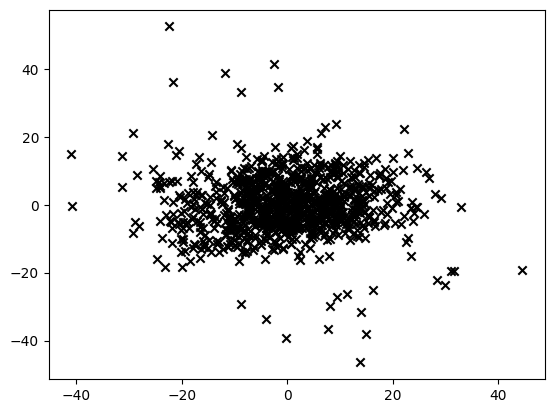

In [11]:
import matplotlib.pyplot as plt
fix, ax = plt.subplots()
ax.scatter(Xy_project[:, 0], Xy_project[:, 1], marker='x', color='black')
plt.show()

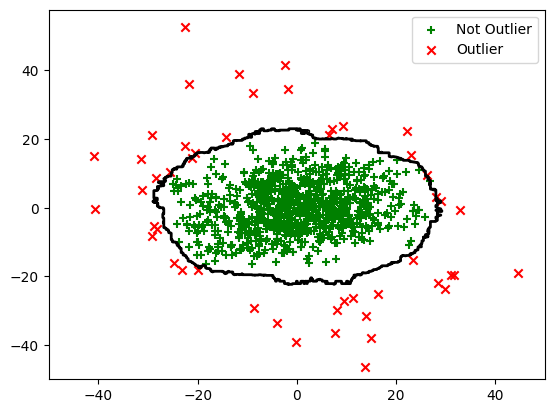

(49, 2)


In [13]:
from sklearn.ensemble import IsolationForest

xx, yy = np.meshgrid(np.linspace(-50, 50, 1000), np.linspace(-50, 50, 1000))

iso_forest = IsolationForest(contamination=0.05)
outliers = iso_forest.fit_predict(Xy_project)
mask_outliers_out = outliers != -1
Xy_project_not_outliers = Xy_project[mask_outliers_out, :]
Xy_project_outliers = Xy_project[~mask_outliers_out, :]
fig, ax = plt.subplots()
ax.scatter(Xy_project_not_outliers[:, 0], Xy_project_not_outliers[:, 1], marker='+', color='green')
ax.scatter(Xy_project_outliers[:, 0], Xy_project_outliers[:, 1], marker='x', color='red')
Z = iso_forest.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")
plt.legend(['Not Outlier', 'Outlier'])
plt.show()

print(Xy_project_outliers.shape)

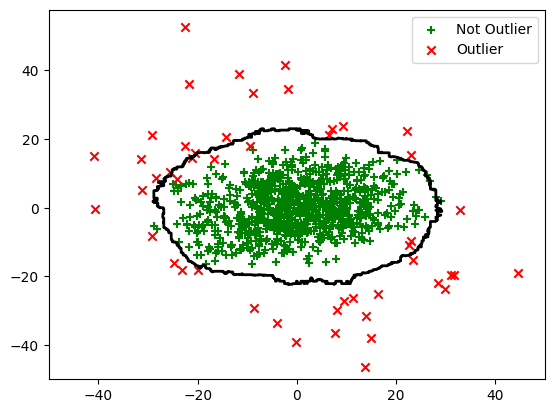

(49, 2)


In [14]:
from sklearn.covariance import EllipticEnvelope

xx, yy = np.meshgrid(np.linspace(-50, 50, 1000), np.linspace(-50, 50, 1000))

elliptic_env = EllipticEnvelope(contamination=0.05)
outliers = elliptic_env.fit_predict(Xy_project)
mask_outliers_out = outliers != -1
Xy_project_not_outliers = Xy_project[mask_outliers_out, :]
Xy_project_outliers = Xy_project[~mask_outliers_out, :]
fig, ax = plt.subplots()
ax.scatter(Xy_project_not_outliers[:, 0], Xy_project_not_outliers[:, 1], marker='+', color='green')
ax.scatter(Xy_project_outliers[:, 0], Xy_project_outliers[:, 1], marker='x', color='red')
Z = iso_forest.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")
plt.legend(['Not Outlier', 'Outlier'])
plt.show()

print(Xy_project_outliers.shape)

In [15]:
# I think since the shape is more Gaussian like, EllipticEnvelope might be a better fit

In [16]:
# Now we filter out the outliers in the two dimensional space
X_train, y_train = X_train[mask_outliers_out], y_train[mask_outliers_out]

In [18]:
print(X_train.shape, y_train.shape)

(920, 828) (920, 1)


In [20]:
from sklearn.feature_selection import mutual_info_regression
mutual_info_w_target = mutual_info_regression(X_train, y_train.squeeze())
X_train, X_test = X_train[:, mutual_info_w_target > 0.1], X_test[:, mutual_info_w_target > 0.1]
print(X_train.shape, X_test.shape)

(920, 34) (243, 34)


In [24]:
def filter_multicolinearity(X_train, sigma):
    corr_matrix = np.triu(np.corrcoef(X_train, rowvar=False))
    np.fill_diagonal(corr_matrix, val=0)
    mask_multicorr = (corr_matrix < sigma).all(axis=1)
    return mask_multicorr

In [25]:
sigma_th = 0.75
mask_features = filter_multicolinearity(X_train, sigma_th)
X_train = X_train[:, mask_features]
X_test = X_test[:, mask_features]
print(X_train.shape, X_test.shape)

(920, 24) (243, 24)


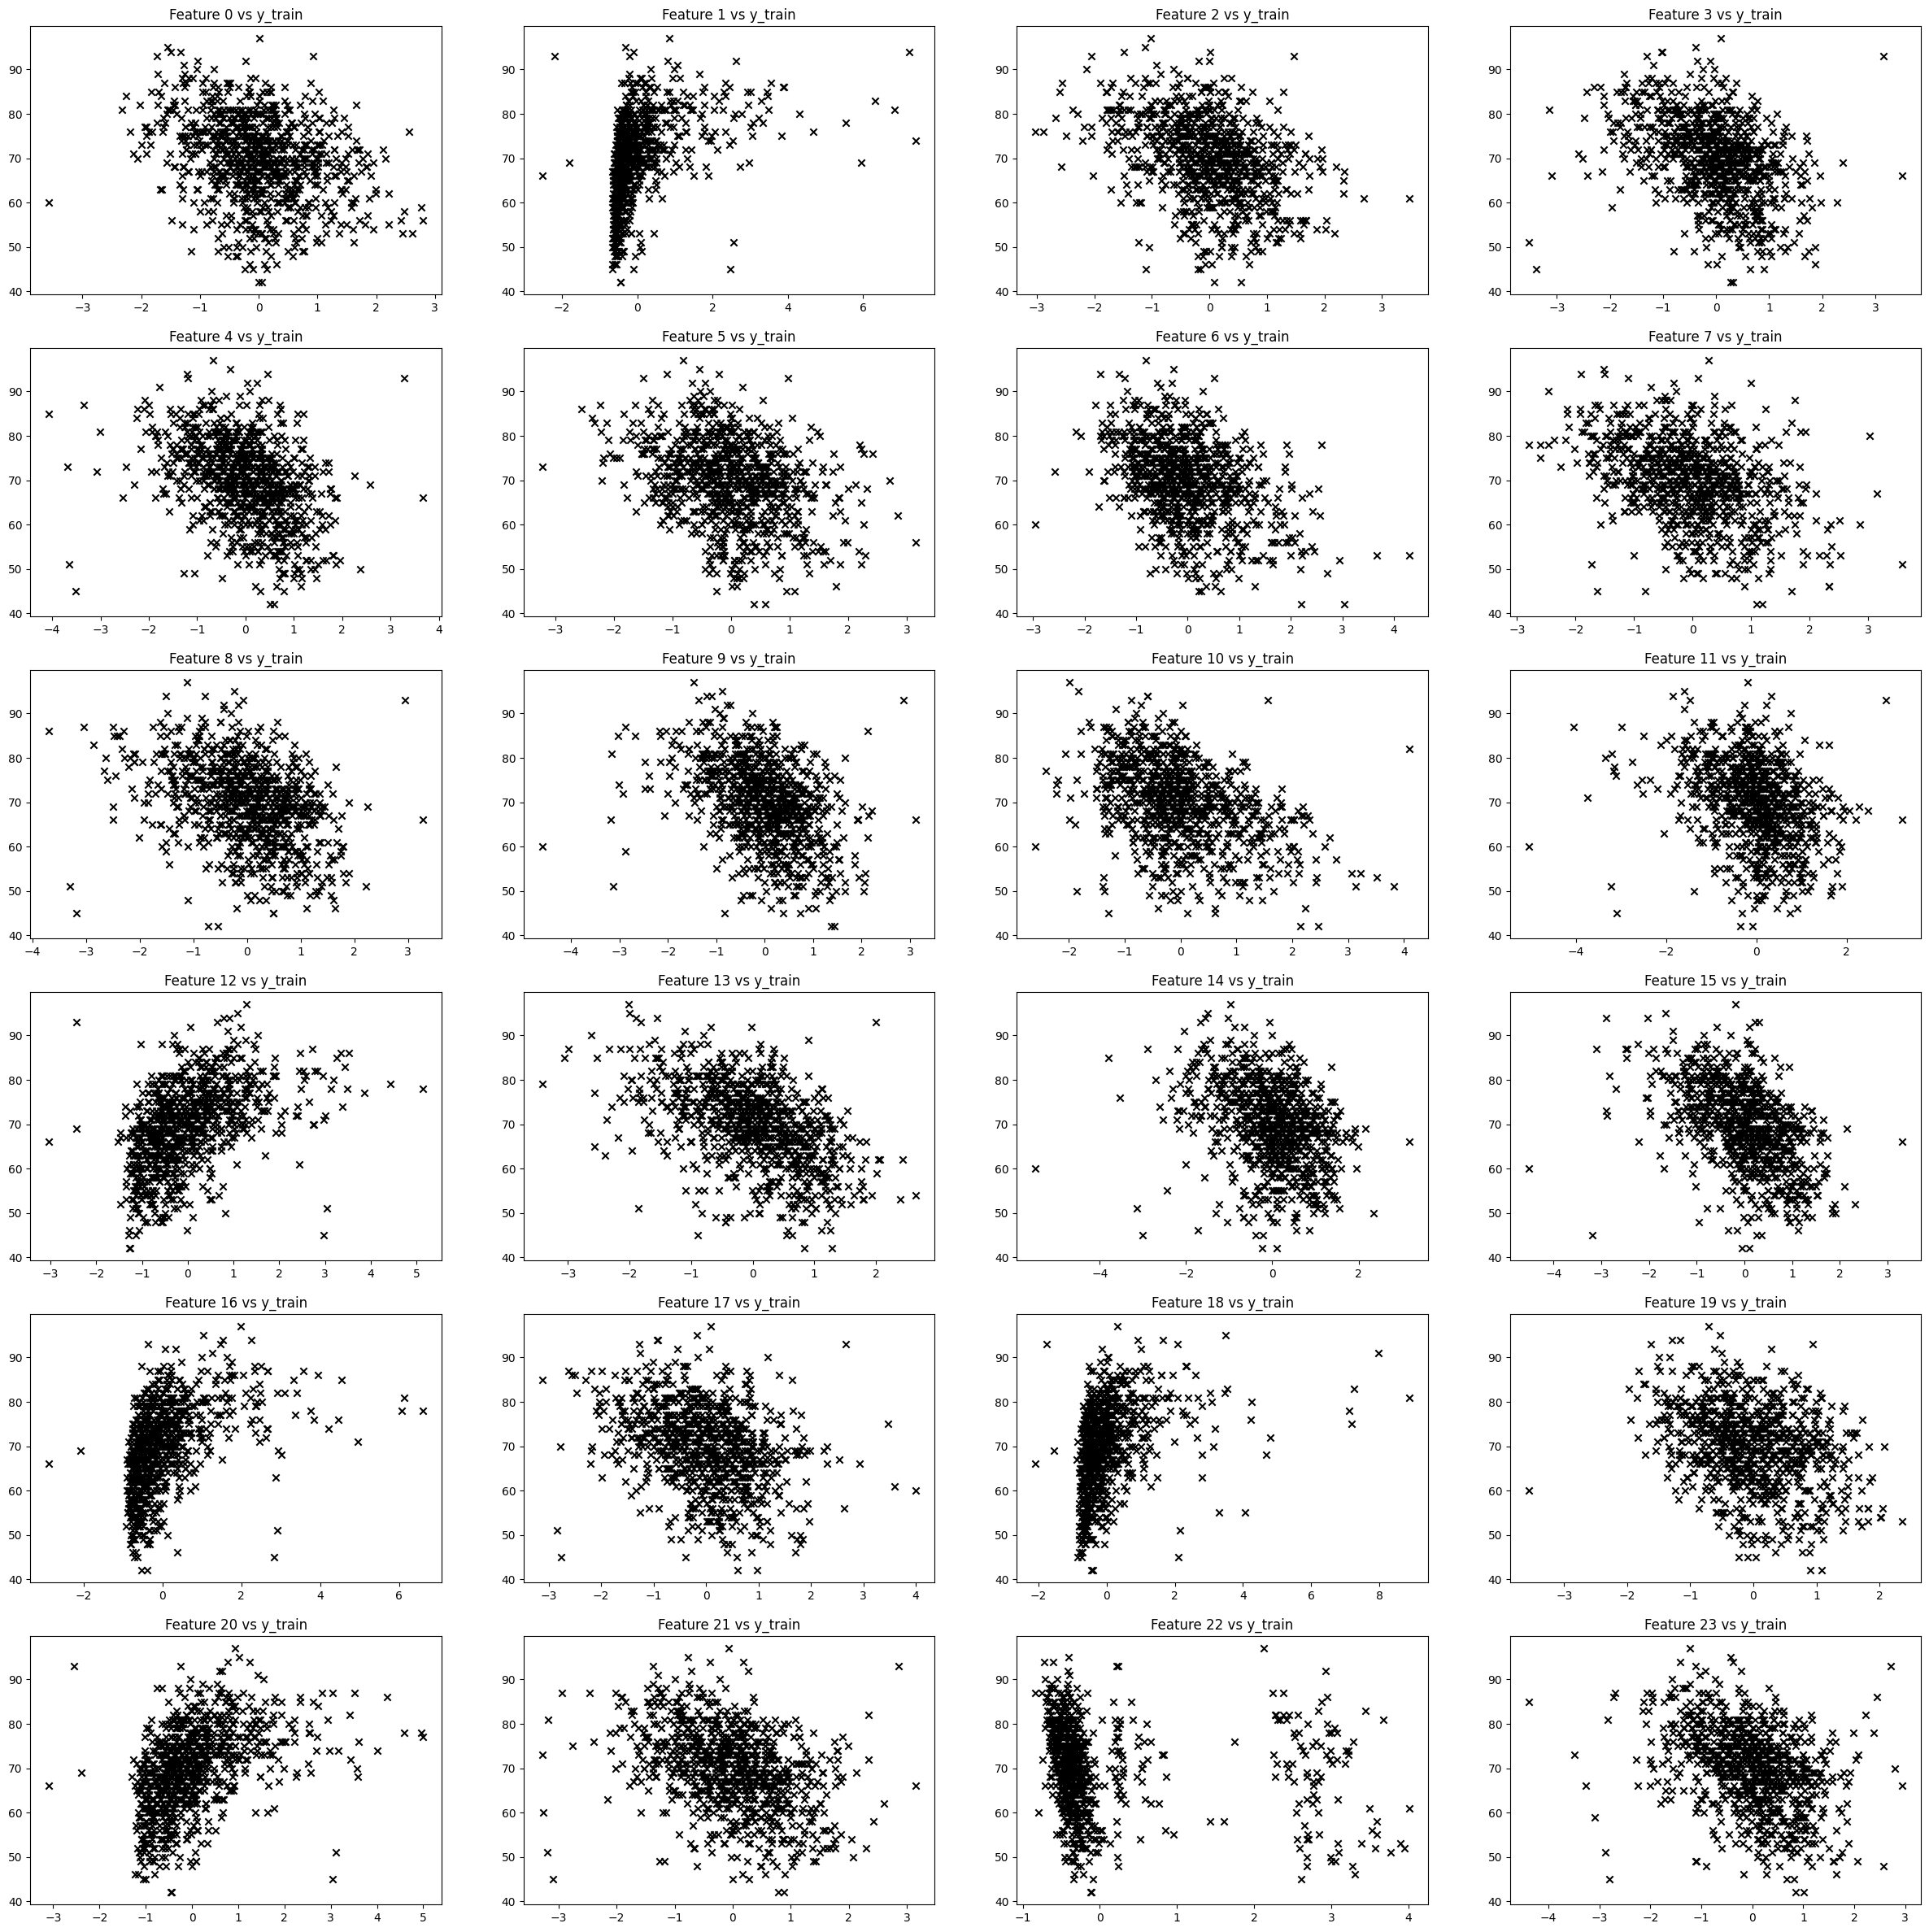

In [26]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(6, 4, figsize=(30, 30))
for i in range(axes.size):
    axes[i // 4, i % 4].scatter(X_train[:, i], y_train, marker='x', color='black')
    axes[i // 4, i % 4].set_title(f'Feature {i} vs y_train')

plt.show()

In [27]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

kernel_ridge = Pipeline([ 
    ('kernel_ridge', KernelRidge())
])
param_grid = { 
    'kernel_ridge__alpha': np.logspace(-6, 4, 20), 
    'kernel_ridge__kernel': ['rbf', 'laplacian', 'cosine', 'poly'], 
    'kernel_ridge__gamma': np.logspace(-6, 6, 20)
}

grid = GridSearchCV(estimator=kernel_ridge, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('kernel_ridge', KernelRidge())]),
             n_jobs=-1,
             param_grid={'kernel_ridge__alpha': array([1.00000000e-06, 3.35981829e-06, 1.12883789e-05, 3.79269019e-05,
       1.27427499e-04, 4.28133240e-04, 1.43844989e-03, 4.83293024e-03,
       1.62377674e-02, 5.45559478e-02, 1.83298071e-01, 6.15848211e-01,
       2.06913808e+00, 6.95192...
                         'kernel_ridge__gamma': array([1.00000000e-06, 4.28133240e-06, 1.83298071e-05, 7.84759970e-05,
       3.35981829e-04, 1.43844989e-03, 6.15848211e-03, 2.63665090e-02,
       1.12883789e-01, 4.83293024e-01, 2.06913808e+00, 8.85866790e+00,
       3.79269019e+01, 1.62377674e+02, 6.95192796e+02, 2.97635144e+03,
       1.27427499e+04, 5.45559478e+04, 2.33572147e+05, 1.00000000e+06]),
                         'kernel_ridge__kernel': ['rbf', 'laplacian', 'cosine',
                                                  'poly']},
             scoring='r2', verbose=1)

In [28]:
from sklearn.metrics import r2_score
best_rbf_ridge = grid.best_estimator_
print(f'Train r2 score :: {r2_score(y_train, best_rbf_ridge.predict(X_train))}')
print(f'Test r2 score :: {r2_score(y_test, best_rbf_ridge.predict(X_test))}')

Train r2 score :: 0.7140766783764245
Test r2 score :: 0.48126440107225044


In [30]:
y_pred = best_rbf_ridge.predict(X_test)

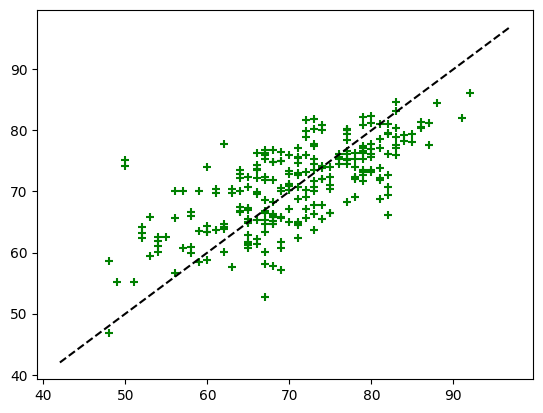

In [31]:
fig, ax = plt.subplots()
ax.scatter(x=y_test, y=y_pred, label='Ygt vs Ypred', marker='+', color='green')
ax.plot([y.min(), y.max()], [y.min(), y.max()], '--k')
plt.show()